In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/yolotestdata/182.jpg
/kaggle/input/yolotestdata/185.jpg
/kaggle/input/yolotestdata/176.jpg
/kaggle/input/yolotestdata/163.jpg
/kaggle/input/yolotestdata/160.jpg
/kaggle/input/yolotestdata/178.jpg
/kaggle/input/yolotestdata/177.jpg
/kaggle/input/yolotestdata/179.jpg
/kaggle/input/yolotestdata/166.jpg
/kaggle/input/yolotestdata/180.jpg
/kaggle/input/yolotestdata/164.jpg
/kaggle/input/yolotestdata/161.jpg
/kaggle/input/yolotestdata/183.jpg
/kaggle/input/yolotestdata/165.jpg
/kaggle/input/yolotestdata/181.jpg
/kaggle/input/yolotestdata/184.jpg
/kaggle/input/yolotestdata/162.jpg
/kaggle/input/yolotestdata/18.jpg
/kaggle/input/yolotestdata/175.jpg
/kaggle/input/content/Human-Segmentation-Dataset-master/README.md
/kaggle/input/content/Human-Segmentation-Dataset-master/helper.py
/kaggle/input/content/Human-Segmentation-Dataset-master/train.csv
/kaggle/input/content/Human-Segmentation-Dataset-master/Ground_Truth/173.png
/kaggle/input/content/Human-Segmentation-Dataset-master/Groun


# Task 1 : Set up gpu runtime environment

In [4]:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=e1dc728cd89139bd39323993fedd67418f8142ac2a88e435f37bc481e6da7a8f
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=cd76cf7fd12efbeabdb2ae6fe0db40c0a8c8bbd87281a5708d7295d82e817bae
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientne

In [4]:
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-swdbtwcd
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-swdbtwcd
  Resolved https://github.com/albumentations-team/albumentations to commit 972da69c39e5932191e61b6e932d6fef9ca90303
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


original author of the dataset : https://github.com/VikramShenoy97/Human-Segmentation-Dataset

# Download Dataset

original author of the dataset : https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [5]:
!git clone https://github.com/Anks-9/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 7 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (7/7), 13.65 MiB | 19.55 MiB/s, done.


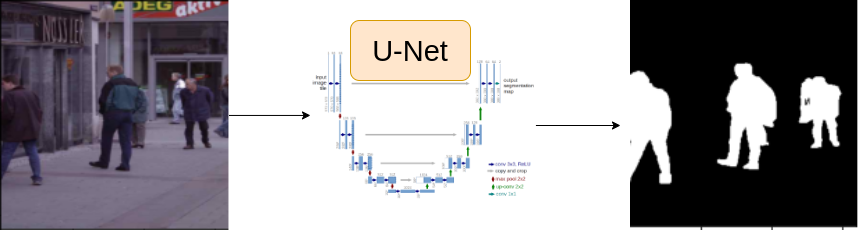

# **Some Common Imports**

In [3]:
import sys
sys.path.append('/kaggle/input/Human-Segmentation-Dataset-master')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task 2: Setup Configurations

In [5]:
CSV_FILE = '/kaggle/input/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/kaggle/input/content'

DEVICE = 'cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [6]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [12]:
row = df.iloc[3]
# # Extract image and mask paths
image_path = row.images
mask_path = row.masks

image = cv2.imread('/kaggle/input/content/'+ image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread('/kaggle/input/content/'+ mask_path, cv2.IMREAD_GRAYSCALE)

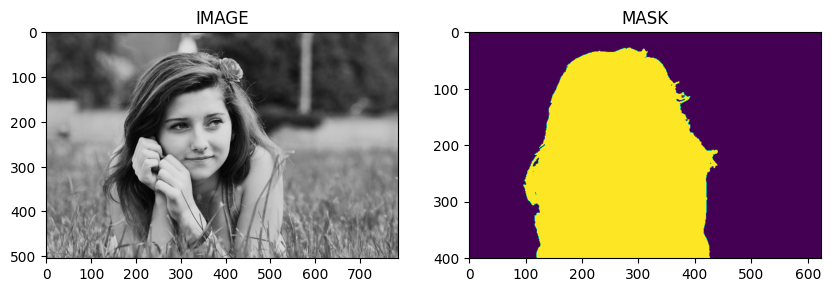

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('MASK')
ax2.imshow(mask)

In [14]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state= 42)


# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [15]:
import albumentations as A

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.16 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [16]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),   
        A.HorizontalFlip(p=0.5),        
        A.VerticalFlip(p=0.5),          
    ], is_check_shapes=False)           # Disable shape check in Compose

def get_valid_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),   
    ], is_check_shapes=False)           # Disable shape check in Compose

# Task 4 : Create Custom Dataset

In [16]:
from torch.utils.data import Dataset

In [17]:
class SegmentationDataset(Dataset):
    
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row.images
        mask_path = row.masks

        image = cv2.imread('/kaggle/input/content/'+ image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread('/kaggle/input/content/'+ mask_path, cv2.IMREAD_GRAYSCALE) #(h, w, c)
        mask = np.expand_dims(mask, axis = -1)

        if self.augmentations:
            data = self.augmentations(image = image, mask = mask)
            image = data['image']
            mask = data['mask']

      #(h,w,c) -> (c, h ,w)

        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [18]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [19]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


In [20]:
def show_image(image,mask,pred_image = None):
    
#     image = image.cpu()
#     mask = mask.cpu()
    
    if pred_image == None:
        
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
    elif pred_image != None :
#         pred_image = pred_image.cpu()
        
        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))
        
        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')
        
        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')
        

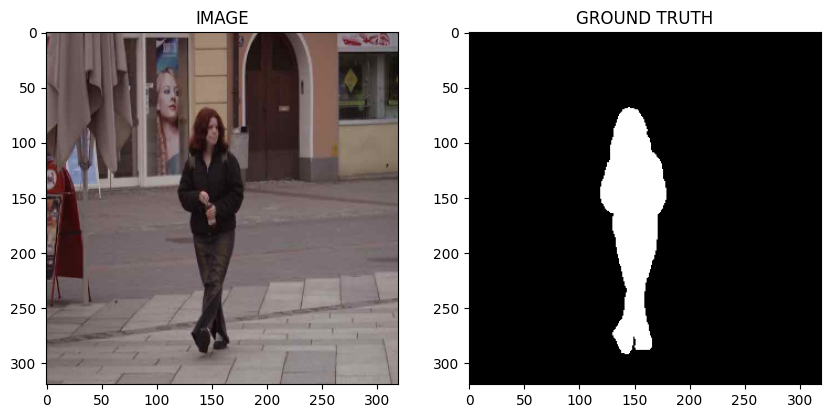

In [22]:
idx = 15

image, mask = trainset[idx]
show_image(image, mask)

# Task 5 : Load dataset into batches

In [23]:
from torch.utils.data import DataLoader

In [24]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [26]:
print(f"Total number of batches in trainloader : {len(trainloader)}")
print(f"Total number of batches in validloader : {len(validloader)}")

Total number of batches in trainloader : 15
Total number of batches in validloader : 4


In [27]:
for images, masks in trainloader:
    print(f"one batch image shape : {images.shape}")
    print(f"one batch mask shape : {masks.shape}")
    break

one batch image shape : torch.Size([16, 3, 320, 320])
one batch mask shape : torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [29]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [30]:
class SegmentationModel(nn.Module):
    
    def __init__(self):
        super(SegmentationModel, self).__init__()
        
        self.arc = smp.Unet(
            encoder_name = ENCODER,
            encoder_weights = WEIGHTS,
            in_channels = 3,
            classes = 1,
            activation = None
        )
        
    def forward(self, images, masks= None):
        
        logits = self.arc(images)

        if masks != None:
            loss1 = DiceLoss(mode = 'binary')(logits, masks)
            loss2 = nn.BCEWithLogitsLoss()(logits, masks)
            return logits, loss1 + loss2
        
        return logits

In [31]:
model = SegmentationModel()
model.to(DEVICE);

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 82.2MB/s]


# Task 7 : Create Train and Validation Function

In [32]:
def eval_fn(model, data_loader):
    
    model.eval()
    total_loss = 0.0
    
    
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            
            images = images.to(DEVICE)
            masks = masks.to(DEVICE)
            
            logits, loss = model(images, masks)
            
            total_loss += loss.item()

    return total_loss / len(data_loader)

In [33]:
def train_fn(model, data_loader, optimizer):
    
    model.train()
    total_loss = 0.0

    for images, masks in tqdm(data_loader):
        
        images = images.to(DEVICE)
        masks = masks.to(DEVICE)
        
        optimizer.zero_grad()
        logits, loss = model(images, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(data_loader)

# Task 8 : Train Model

In [34]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

In [35]:
best_valid_loss = np.Inf

for epoch in range(EPOCHS):
    
    train_loss = train_fn(model, trainloader, optimizer)
    valid_loss = eval_fn(model, validloader)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print("Saved Best Model!")

    print(f"Epoch : {epoch+1}/{EPOCHS}")
    print(f"Train Loss : {train_loss:.4f}")
    print(f"Valid Loss : {valid_loss:.4f}")

100%|██████████| 4/4 [00:01<00:00,  2.49it/s]


Saved Best Model!
Epoch : 1/25
Train Loss : 0.8282
Valid Loss : 0.7881


100%|██████████| 4/4 [00:00<00:00,  5.15it/s]


Saved Best Model!
Epoch : 2/25
Train Loss : 0.3744
Valid Loss : 0.4972


100%|██████████| 4/4 [00:00<00:00,  5.09it/s]


Saved Best Model!
Epoch : 3/25
Train Loss : 0.2918
Valid Loss : 0.3337


100%|██████████| 4/4 [00:00<00:00,  4.65it/s]


Saved Best Model!
Epoch : 4/25
Train Loss : 0.2475
Valid Loss : 0.2639


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


Epoch : 5/25
Train Loss : 0.2820
Valid Loss : 0.2777


100%|██████████| 4/4 [00:00<00:00,  5.18it/s]


Epoch : 6/25
Train Loss : 0.2649
Valid Loss : 0.3533


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch : 7/25
Train Loss : 0.2211
Valid Loss : 0.2905


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]


Saved Best Model!
Epoch : 8/25
Train Loss : 0.2113
Valid Loss : 0.2091


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


Epoch : 9/25
Train Loss : 0.2213
Valid Loss : 0.2928


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 10/25
Train Loss : 0.2171
Valid Loss : 0.2323


100%|██████████| 4/4 [00:00<00:00,  5.03it/s]


Epoch : 11/25
Train Loss : 0.1641
Valid Loss : 0.2135


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch : 12/25
Train Loss : 0.1550
Valid Loss : 0.2158


100%|██████████| 4/4 [00:00<00:00,  5.19it/s]


Saved Best Model!
Epoch : 13/25
Train Loss : 0.1284
Valid Loss : 0.1673


100%|██████████| 4/4 [00:00<00:00,  5.13it/s]


Saved Best Model!
Epoch : 14/25
Train Loss : 0.1425
Valid Loss : 0.1663


100%|██████████| 4/4 [00:00<00:00,  4.95it/s]


Epoch : 15/25
Train Loss : 0.1594
Valid Loss : 0.1910


100%|██████████| 4/4 [00:00<00:00,  4.35it/s]


Epoch : 16/25
Train Loss : 0.1701
Valid Loss : 0.2101


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


Epoch : 17/25
Train Loss : 0.1390
Valid Loss : 0.1739


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch : 18/25
Train Loss : 0.1527
Valid Loss : 0.2250


100%|██████████| 4/4 [00:00<00:00,  4.97it/s]


Epoch : 19/25
Train Loss : 0.1541
Valid Loss : 0.2230


100%|██████████| 4/4 [00:00<00:00,  4.93it/s]


Epoch : 20/25
Train Loss : 0.1516
Valid Loss : 0.2732


100%|██████████| 4/4 [00:00<00:00,  5.02it/s]


Epoch : 21/25
Train Loss : 0.1257
Valid Loss : 0.2881


100%|██████████| 4/4 [00:00<00:00,  4.99it/s]


Epoch : 22/25
Train Loss : 0.1576
Valid Loss : 0.2261


100%|██████████| 4/4 [00:00<00:00,  4.83it/s]


Epoch : 23/25
Train Loss : 0.1423
Valid Loss : 0.2055


100%|██████████| 4/4 [00:00<00:00,  4.54it/s]


Epoch : 24/25
Train Loss : 0.1378
Valid Loss : 0.1784


100%|██████████| 4/4 [00:00<00:00,  4.58it/s]

Epoch : 25/25
Train Loss : 0.1364
Valid Loss : 0.2941


# Task 9 : Inference

In [36]:
idx = 28

model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))
image, mask = validset[idx]


logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5) * 1.0

/tmp/ipykernel_31/3774682480.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/best_model.pth'))


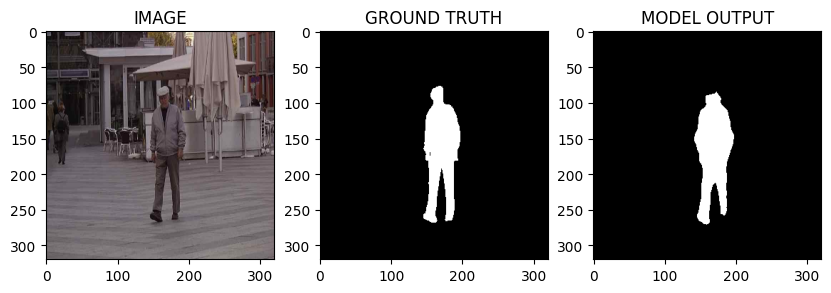

In [37]:
show_image(image, mask, pred_mask.detach().cpu().squeeze(0))

# For further updates follow me on...

Linkedin : https://www.linkedin.com/in/ankitbartwal/